In [1]:
import pyemma
pyemma.__version__

'2.1.1'

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import msmbuilder
from msmbuilder.msm.ratematrix import ContinuousTimeMSM
import scipy
from msmtools.analysis.dense.decomposition import eigenvectors, eigenvalues
import operator

In [4]:
# get the DPCA dtrajs, mapped to the rama states
dtraj_full_CG = np.load('./dtraj_DPCA_CG_mapped_to_rama.npy')
dtraj_full_CG = [ dtraj for dtraj in dtraj_full_CG ]
cc_full = np.load('../BMSM/dtraj/cc_full.npy')

In [5]:
# ITS test for the CG model
lags = np.linspace(1,500,100).astype(int)
its_CG = msm.timescales_msm(dtraj_full_CG, lags=lags, nits=len(cc_full)-1)

24-01-17 08:00:53 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[0] WARNING  Changed user setting nits to the number of available timescales nits=26


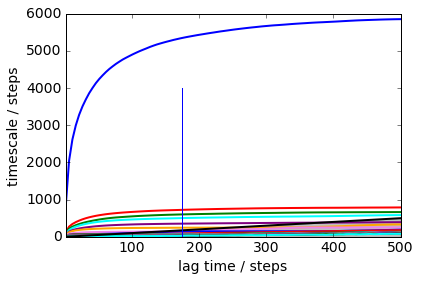

In [6]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its_CG, ylog=False, units='steps', linewidth=2)
plt.plot(175*np.ones(5),1000*np.arange(5))
#xlim(0, 1100); ylim(0, 2500);

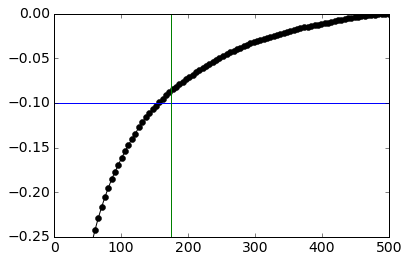

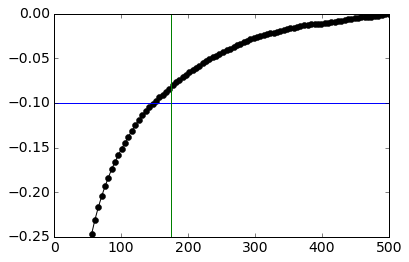

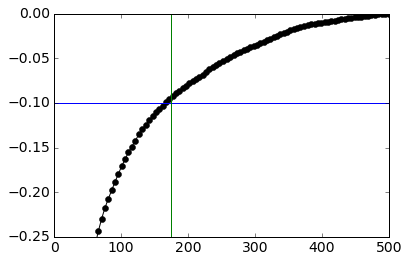

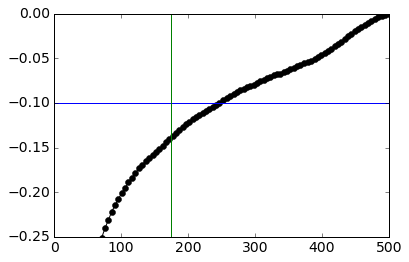

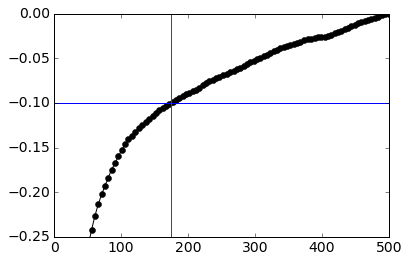

In [7]:
# also measure the relative error compared to the converged value
N_ts = 5
tau_check = 175
tol_check = 0.1
for ind in range(N_ts):
    ts = its_CG.timescales[:,ind]
    plt.plot(lags,(ts-ts[-1])/ts[-1],marker='o',color='k')
    plt.plot(lags,-tol_check*np.ones(len(lags)))
    plt.plot(tau_check*np.ones(len(lags)), 0.05*np.arange(len(lags))-0.25)
    plt.ylim([-0.25,0])
    plt.show()

In [8]:
# choose tau and make the model
tau_CG = 175
mle_CG = msm.bayesian_markov_model(dtraj_full_CG,tau_CG,nsamples=100)

In [9]:
# choose tau and make the model
np.save('T_mle_trim',mle_CG.transition_matrix)
np.savetxt('tau_CG.dat',[tau_CG])

In [11]:
# now let's extend this model to include all the states
cc_trim = np.load('cc_full_trim.npy')

In [42]:
coil_ind = 31
p_coil = mle_CG.stationary_distribution[-1]
p_uns = 1e-6
T_mle_full = np.zeros(shape=(len(cc_full),len(cc_full)))
for i_ind,statei in enumerate(cc_full):
    I_ind = np.where( np.all(statei==cc_trim,axis=1) == True )[0]
    for j_ind,statej in enumerate(cc_full):
        J_ind = np.where( np.all(statej==cc_trim,axis=1) == True )[0]
        if ((len(I_ind)!=0)and(len(J_ind)!=0)): # this state already exists
            T_mle_full[i_ind,j_ind] = mle_CG.transition_matrix[I_ind[0],J_ind[0]]
        elif ((len(I_ind)!=0)and(len(J_ind)==0)): # J does not exist
            if (i_ind==coil_ind):
                T_mle_full[i_ind,j_ind] = p_uns / p_coil
            else:
                T_mle_full[i_ind,j_ind] = 0.
        elif ((len(I_ind)==0)and(len(J_ind)!=0)): # I does not exist
            if (j_ind==coil_ind):
                T_mle_full[i_ind,j_ind] = 1.
            else:
                T_mle_full[i_ind,j_ind] = 0.
        else: # neither exist
            T_mle_full[i_ind,j_ind] = 0.
T_mle_full[coil_ind] /= np.sum(T_mle_full,axis=1)[coil_ind]

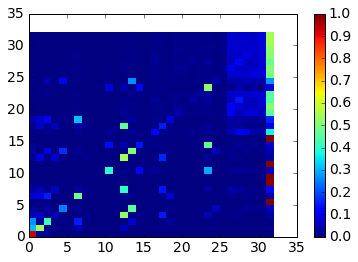

In [43]:
plt.pcolor(T_mle_full)
plt.colorbar()

In [46]:
test = msm.markov_model(T_mle_full)
test.stationary_distribution

array([  4.05744322e-01,   4.78713029e-02,   2.50021100e-02,
         3.76481724e-03,   7.01277308e-03,   9.99990000e-07,
         2.41358007e-02,   9.70218319e-04,   9.99990000e-07,
         9.99990000e-07,   5.56194455e-03,   9.99990000e-07,
         3.10261266e-02,   1.90343924e-02,   4.93338815e-03,
         9.99990000e-07,   6.26893518e-03,   1.07215301e-02,
         5.63823734e-03,   5.20481183e-03,   4.69681956e-03,
         4.42717724e-03,   4.09804237e-03,   2.01228121e-02,
         4.00448976e-03,   4.11243380e-03,   2.92917121e-02,
         3.04455554e-02,   2.81316141e-02,   2.52060398e-02,
         3.09049946e-02,   2.11662599e-01])

<function matplotlib.pyplot.pcolor>

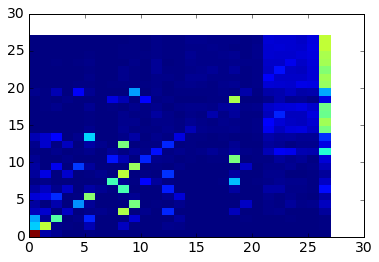

In [47]:
plt.pcolor(mle_CG.transition_matrix)
plt.pcolor

In [52]:
mu_mapped = np.zeros(len(cc_full))
for i_ind,statei in enumerate(cc_full):
    I_ind = np.where( np.all(statei==cc_trim,axis=1) == True )[0]
    if(len(I_ind)!=0):
        mu_mapped[i_ind] = mle_CG.stationary_distribution[I_ind[0]]
    else:
        mu_mapped[i_ind] = 0.

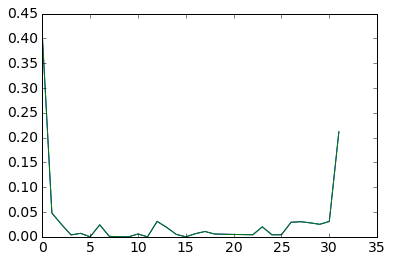

In [53]:
plt.plot(test.stationary_distribution)
plt.plot(mu_mapped)

In [55]:
mu_mapped-test.stationary_distribution

array([  4.05744322e-06,   4.78713029e-07,   2.50021100e-07,
         3.76481724e-08,   7.01277308e-08,  -9.99990000e-07,
         2.41358007e-07,   9.70218318e-09,  -9.99990000e-07,
        -9.99990000e-07,   5.56194455e-08,  -9.99990000e-07,
         3.10261266e-07,   1.90343924e-07,   4.93338815e-08,
        -9.99990000e-07,   6.26893518e-08,   1.07215301e-07,
         5.63823734e-08,   5.20481183e-08,   4.69681956e-08,
         4.42717724e-08,   4.09804237e-08,   2.01228121e-07,
         4.00448976e-08,   4.11243380e-08,   2.92917121e-07,
         3.04455554e-07,   2.81316141e-07,   2.52060398e-07,
         3.09049946e-07,  -2.88337401e-06])

In [56]:
# save the full model
np.save('T_mle',T_mle_full)